This code test for violations of noncontextuality inequality of a scenario in a public system

In [1]:
import numpy as np
import random
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import math
from google.colab import files

In [2]:
def compute_projection_matrix(vectors):
  # Calculate the basis for the subspace generated by the matrices
  subspace_basis = np.vstack(vectors).T
  # Calculate the projection matrix onto the subspace
  projection_matrix = subspace_basis@np.linalg.inv(subspace_basis.T.conj()@subspace_basis)@subspace_basis.T.conj()

  return projection_matrix

def nearest_int(x):
  if isinstance(x, complex):
    x = round(x.real)
  else:
    rounded_result = round(x)
  return x

# get eigenbasis
def get_projections(matrix):
  eigen_values,eigen_vectors=np.linalg.eig(matrix)

  eigen_values=list(map(nearest_int,eigen_values))

  #dictionary that will store eigenbasis corresponding to each eigenvalue key
  eigen_basis={}

  # Iterate over the eigenvalues and eigenvectors
  for eigen_value_index in range(len(eigen_values)):

    #CHECK IF RIGHT COLUMN EIGENVECTOR
    # Check if the eigenvalue is already in the dictionary
    if eigen_values[eigen_value_index] in eigen_basis:
        eigen_basis[eigen_values[eigen_value_index]].append(eigen_vectors[:,eigen_value_index])
    else:
        eigen_basis[eigen_values[eigen_value_index]] = [eigen_vectors[:,eigen_value_index]]

  #return(eigen_basis)
  projection_matrices={}

  for eigenvalue in eigen_basis.keys():
    projection_matrices[eigenvalue]=compute_projection_matrix(eigen_basis[eigenvalue])


  return(projection_matrices)

In [3]:
def randomStateUniform():
  QuadraticNormRemainder=1
  listOfNorms=[]

  for i in range(3):
    quadraticNorm=np.random.uniform(0,QuadraticNormRemainder)
    listOfNorms.append(quadraticNorm**0.5)
    QuadraticNormRemainder=QuadraticNormRemainder-quadraticNorm

  listOfNorms.append(QuadraticNormRemainder**0.5)
  random.shuffle(listOfNorms)

  angle=np.random.uniform(0,2*math.pi,[4])
  j=1j
  randState=np.array([(listOfNorms[i])*math.cos(angle[i])+(listOfNorms[i])*math.sin(angle[i])*j for i in range(4)])


  return(compute_projection_matrix([randState]))

In [4]:
def measure(state,projectors):

  probability_outcomes={}
  for eigenvalue in projectors.keys():
    probability_outcomes[eigenvalue]=np.trace(projectors[eigenvalue]@state@(projectors[eigenvalue].conj().T))
  outcome = random.choices(list(probability_outcomes.keys()), list(probability_outcomes.values()))[0]
  resulting_state=(projectors[outcome]@state@(projectors[outcome].conj().T))/np.trace(projectors[outcome].conj().T@projectors[outcome]@state)

  return outcome, resulting_state

In [5]:
def PS(scenario,number_of_passerby,initial_state,number_of_rounds):

  context_keys_list=list(scenario.contexts.keys())

  sum_results_context=dict(zip(context_keys_list,[0 for i in scenario.contexts]))
  number_measurements_context=dict(zip(context_keys_list,[0 for i in scenario.contexts]))

  for i in range(number_of_rounds):

    state=initial_state

    context_measured=random.choice(context_keys_list)
    measurement_order=random.sample(range(len(scenario.contexts[context_measured])), len(scenario.contexts[context_measured]))
    order_of_access=random.sample(range(number_of_passerby+1), number_of_passerby+1)

    round_results=[]

    for j in range(3):
      for n in order_of_access:
        if not n:
          outcome,state=measure(state,scenario.projectors[scenario.contexts[context_measured][measurement_order[j]]])
          round_results.append(outcome)
        else:
          _,state=measure(state,scenario.projectors[random.randint(0,len(scenario.projectors)-1)])


    sum_results_context[context_measured]+=np.prod(round_results)
    number_measurements_context[context_measured]+=1

  average_values={}
  for key in scenario.contexts.keys():
    average_values[key]=sum_results_context[key]/number_measurements_context[key]


  return(scenario.evaluate_expression(average_values))

In [10]:
def PSPlot(resultPlot,passerbyRange):

  plt.figure(figsize=(10, 10))


  for i in range(len(passerbyRange)):
    plt.plot(passerbyRange[i],6*(5/9)**(2*passerbyRange[i]),marker="+",markersize=18,markeredgewidth=3, markeredgecolor='g', linestyle="none")
    for j in resultPlot[i]:
      plt.plot(passerbyRange[i],j,marker="x", markersize=15,markeredgewidth=1, markeredgecolor='k', linestyle="none")
  plt.fill_between([-1,max(passerbyRange)+1], -1, 4, color = "gainsboro")


  plt.xlim([min(passerbyRange)-0.08, max(passerbyRange)+0.08])
  plt.ylim([0,6.3])
  plt.xticks([i for i in range(max(passerbyRange)+1)],fontsize=16)
  plt.yticks([i for i in range(7)],fontsize=16)
  plt.xlabel("Number of passerby observers (N)",fontsize=22)
  plt.ylabel("$\Sigma$",fontsize=26)


  l1=mpatches.Patch(facecolor='white', edgecolor="k")
  l2=mpatches.Patch(facecolor='gainsboro', edgecolor="k")
  l3=mlines.Line2D([], [],marker="x", linestyle="none", markersize=15,markeredgewidth=1, markeredgecolor='k')
  l4=mlines.Line2D([], [],marker="+", linestyle="none",markersize=15,markeredgewidth=3, markeredgecolor='g')

  handles=[l1,l2,l3,l4]
  labels=['Contextual','Noncontextual','PS Simulation',"$6(\\frac{5}{9})^{2N}$"]

  plt.legend(handles,labels, handlelength=2, handleheight=2,fontsize=18)


  plt.savefig("PPSFigure.png")
  files.download("PPSFigure.png")
  return(0)

In [9]:
def manyPS(scenario,passerbyRange,numSimulations,number_of_rounds):
  resultPlot=[]
  lenpasserby=len(passerbyRange)
  for i in range(lenpasserby):
    resultPlot.append([])

  for i in range(lenpasserby):
    for j in range(numSimulations):
      resultPlot[i].append(PS(scenario,passerbyRange[i],randomStateUniform(),number_of_rounds))
    print(str(passerbyRange[i])+"  done")

  PSPlot(resultPlot,passerbyRange)
  return(resultPlot,passerbyRange)

In [6]:
class KS_Scenario:
  def __init__(self, measurements, contexts, equation):
    self.measurements=measurements
    self.contexts=contexts
    self.equation=equation
    self.projectors=[get_projections(A) for A in self.measurements]

  def evaluate_expression(self, average_values):
    # Replace variable names in the expression with their values and evaluate it
    try:
      result = eval( self.equation, average_values)
      return result
    except Exception as e:
      print(e)



In [7]:
#define pauli matrices

sigma_x=np.array([[0,1],
                  [1,0]])

sigma_y=np.array([[0,-1j],
                  [1j,0]])

sigma_z=np.array([[1,0],
                  [0,-1]])

Id=np.array([[1,0],
             [0,1]])


#Define the measurement of the scenaio

A_11=np.kron(sigma_x,Id)
A_12=np.kron(Id,sigma_x)
A_13=np.kron(sigma_x,sigma_x)
A_21=np.kron(Id,sigma_y)
A_22=np.kron(sigma_y,Id)
A_23=np.kron(sigma_y,sigma_y)
A_31=np.kron(sigma_x,sigma_y)
A_32=np.kron(sigma_y,sigma_x)
A_33=np.kron(sigma_z,sigma_z)


measurements=[A_11,A_12,A_13,A_21,A_22,A_23,A_31,A_32,A_33]
contexts={"C_1":[0,1,2],"C_2":[3,4,5],"C_3":[6,7,8],"C_4":[0,3,6],"C_5":[1,4,7],"C_6":[2,5,8]}
inequality="C_1+C_2+C_3+C_4+C_5-C_6"

#Define the scenario
PM_scenario=KS_Scenario(measurements,contexts,inequality)

/usr/lib/python3.10/random.py:536: ComplexWarning: Casting complex values to real discards the imaginary part
  if not _isfinite(total):


0  done
1  done
2  done
3  done


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

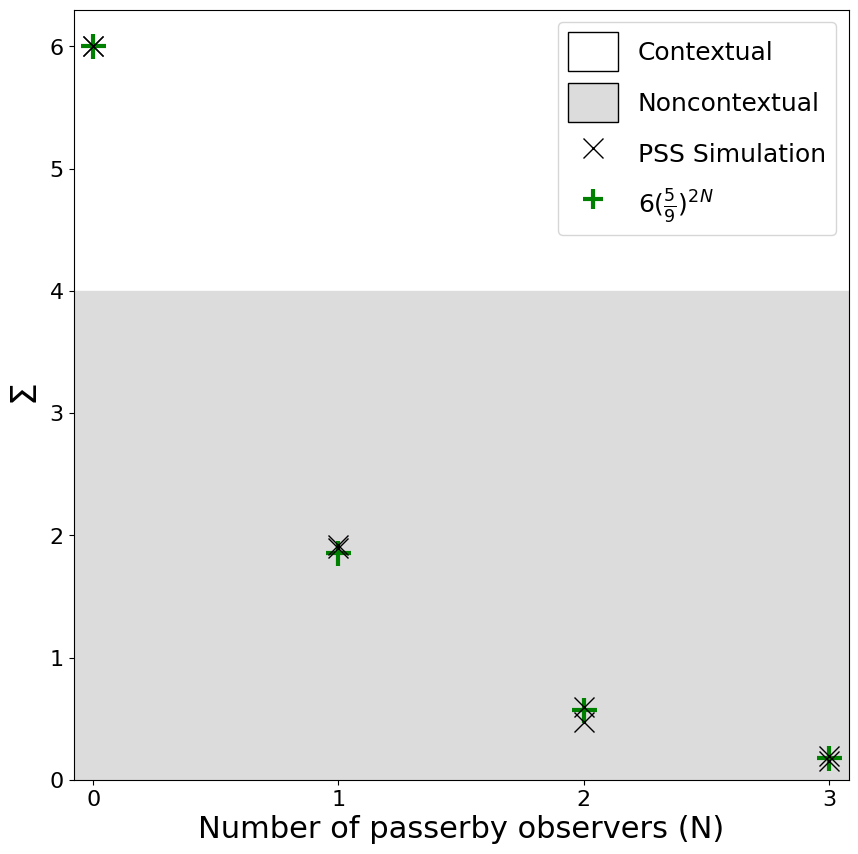

In [11]:
list_of_sigma,passerby_numbers=manyPS(PM_scenario,[0,1,2,3],2,10000)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

0

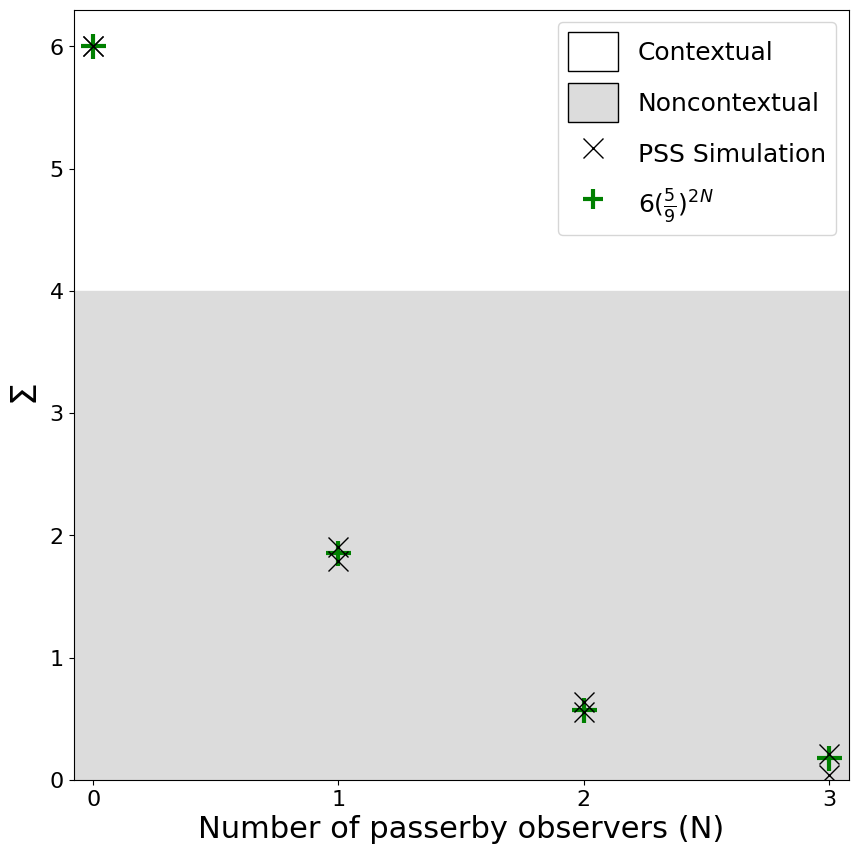

In [ ]:
PSPlot(list_of_sigma,passerby_numbers)